In [2]:
import os
import numpy as np
import pandas as pd
from scipy import interpolate

In [50]:
!ls ../../../data/group15

139_Run000260_000000.txt


In [51]:
data = pd.read_csv('../../../data/Run000260/data_000000.txt')

#adding time column
data['t'] = data['BX_COUNTER']*25 + data['TDC_MEAS']*25/30


#List of conditions to assign a hit to a detector
fpga = data['FPGA'] == 1 
channel = (data['TDC_CHANNEL'] > 64) & (data['TDC_CHANNEL'] <= 128) #condition on TDC_CHANNEL
trigger = data['TDC_CHANNEL'] >= 129 

conditions = [trigger, ~fpga & ~channel, ~fpga & channel, fpga & ~channel, fpga & channel]
values = [0, 1, 2, 3, 4]

#adding detector column
data['DETECTOR'] = np.select(conditions, values)


#List of conditions to assign a hit to a layer
layer_4 = data['TDC_CHANNEL']%4 == 0 
layer_3 = (data['TDC_CHANNEL'] + 2) % 4 == 0
layer_2 = (data['TDC_CHANNEL'] + 1 ) % 4 == 0
layer_1 = (data['TDC_CHANNEL'] + 3) % 4 == 0
trigger = data['TDC_CHANNEL'] >= 129 

#adding layer column
conditions = [trigger, layer_4, layer_3, layer_2, layer_1]
values = [0, 4, 3, 2, 1]

data['LAYER'] = np.select(conditions, values)

#add column coordinate of the cell
def minus64(x):
    if x <=64:
        return x
    else:
        return x - 64
    
data['COLUMN'] = ((data['TDC_CHANNEL'].apply(minus64)
                   - interpolate.BarycentricInterpolator([1,2,3,4],[1,3,2,4])(data['LAYER'])) / 4 + 1).astype(int)

#set column value to 0 when trigger is activate
data.loc[data['DETECTOR'] == 0, 'COLUMN'] = 0

In [52]:
#i consider orbit only with trigger, i drop other trigger raws
data_139 = data.groupby('ORBIT_CNT', group_keys=False).filter(lambda x: 139 in x.TDC_CHANNEL.values)
data_139 = data_139[data_139['TDC_CHANNEL'] != 130]
data_139 = data_139[data_139['TDC_CHANNEL'] != 129]
data_139 = data_139[data_139['TDC_CHANNEL'] != 137]
data_139 = data_139[data_139['TDC_CHANNEL'] != 138]

In [53]:
#identify mutiple events inside the same orbit

def Identify_Events(x):
    
    if (x.t.max() - x.t.min()) < 415:
    
        x['EVENT'] = 1
        return x
    
    else:
        
        t1 = x.t.iloc[0]
        x1 =  x[np.abs(x.t.values - t1) < 415]
        x1['EVENT'] = 1
        
        xc = x[np.abs(x.t.values - t1) >= 415]
        i = 1
        while(xc.size != 0):
            
            i += 1
            t2 = xc.t.iloc[0]
            x2 =  xc[np.abs(xc.t.values - t2) < 415]
            x2['EVENT'] = i
            x1 = pd.concat([x1,x2])
            xc = xc[np.abs(xc.t.values - t2) >= 415]
        
        return x1

In [54]:
#define the function that for esch orbit return the orbit with the values that have difference with the time of the 
#TDC_channel 139 less than the T_max 
#ridondance in the triggers (the sames in different ambiguity), will be solved later
#computing the drift time

def Time_Max_Filer(x):
        
        if (x.DETECTOR==0).sum() == 0:
            return None
            
            
        else:     
            trigger_time = x[x.DETECTOR==0].t.values.min()
            x1 =  x[(x.t.values - trigger_time < 430)*(x.t.values - trigger_time > 0)]
            x1['DRIFT_TIME'] = x1.t.values - trigger_time
            
            return x1

In [55]:
#adding events column
data_139 = data_139.groupby('ORBIT_CNT', group_keys=False).apply(Identify_Events)

In [56]:
#dropping events with less than 2 cells not counting the trigger 
data_139 = data_139.groupby(['ORBIT_CNT', 'EVENT'], group_keys=False).apply(Time_Max_Filer)

In [57]:
#dropping trigger events
data_139 = data_139[data_139['DETECTOR'] != 0]

In [58]:
#dropping events with number of hits hit less than 3 (ambiguity nont solvable)
data_139 = data_139.groupby(['ORBIT_CNT', 'EVENT', 'DETECTOR']).filter(lambda x: len(x) >= 3)

In [59]:
#dropping some columns
data_139 = data_139.drop(['HEAD', 'FPGA', 'TDC_CHANNEL', 'BX_COUNTER', 'TDC_MEAS'], axis = 1)

In [61]:
#this assumption can be deleted in case of particles that pass between two cell
data_139 = data_139.groupby(['ORBIT_CNT','EVENT','DETECTOR']).filter(lambda x: x.LAYER.nunique() >= 3)

In [41]:
data_139.to_csv('../../../data/group15/139_Run000260_000000.txt', index = False)

In [ ]:
#ignorare quello che c'è sotto

In [64]:
data_139 = pd.read_csv('../../../data/group15/139_Run000260_000000.txt')

In [65]:
data_139 = data_139.groupby(['ORBIT_CNT', 'EVENT', 'DETECTOR'], group_keys=False).filter(lambda x: np.unique(x.LAYER.values).size == 4)

In [ ]:
#l4 4 layer costrains 

In [71]:
data_139l4.to_csv('../../../data/group15/139l4_Run000260_000000.txt', index = False)

In [154]:
def close(x):
    
    x1 = x.COLUMN.iloc[0]
    x2 = x.COLUMN.iloc[1]
    x3 = x.COLUMN.iloc[2]
    x4 = x.COLUMN.iloc[3]
    
    if (x2 == x1) or (x2 == x1 + 1):
        if (x3 == x2) or (x3 == x2 - 1):
            if (x4 == x3) or (x4 == x3 + 1):
                if (x4 == x3) or (x4 == x3 - 1):
                    return x
                
    return None

In [85]:
data_139l4 = data_139l4.sort_values(['ORBIT_CNT', 'EVENT', 'DETECTOR','LAYER'])

In [156]:
data_139l4 = data_139l4.groupby('ORBIT_CNT', group_keys=False).apply(close)

In [157]:
data_139l4.groupby(['ORBIT_CNT', 'EVENT', 'DETECTOR','LAYER', 'COLUMN', 'DRIFT_TIME']).sum()

t
ORBIT_CNT  EVENT DETECTOR LAYER COLUMN DRIFT_TIME              
1897516127 1     4        1     7      208.333333  27483.333333
                          2     7      119.166667  27394.166667
                          3     7      139.166667  27414.166667
                          4     7      133.333333  27408.333333
1897566854 1     2        1     3      85.833333   50360.833333
                          2     3      186.666667  50461.666667
                          3     3      88.333333   50363.333333
                          4     3      100.833333  50375.833333
1897619369 1     2        1     10     128.333333  22503.333333
                          2     10     261.666667  22636.666667
                          3     10     270.833333  22645.833333
                          4     10     172.500000  22547.500000
1897747517 2     3        1     2      241.666667  32466.666667
                          2     2      15.000000   32240.000000
                          3     2      190.833333  32415.833333
                          4     2      38.333333   32263.333333
1897759247 1     4        1     13     162.500000  39462.500000
                          2     13     9.166667    39309.166667
                          3     13     94.166667   39394.166667
                          4     13     68.333333   39368.333333
1918245504 1     2        1     14     157.500000  28857.500000
                          2     14     235.000000  28935.000000
                          3     14     209.166667  28909.166667
                          4     14     198.333333  28898.333333
1918304242 1     1        1     2      47.500000   49322.500000
                          2     2      108.333333  49383.333333
                          3     2      44.166667   49319.166667
                          4     2      89.166667   49364.166667
1918306831 2     2        1     3      153.333333  52078.333333
                          2     3      83.333333   52008.333333
...                                                         ...
1920759249 1     3        3     5      18.333333   87343.333333
                          4     5      218.333333  87543.333333
1920761575 1     1        1     11     78.333333   66028.333333
                          2     11     23.333333   65973.333333
                          3     11     75.833333   66025.833333
                          4     11     25.000000   65975.000000
1920763033 1     3        1     10     50.833333   38050.833333
                          2     10     145.833333  38145.833333
                          3     10     54.166667   38054.166667
                          4     10     143.333333  38143.333333
1920766415 1     3        1     6      91.666667   52116.666667
                          2     6      163.333333  52188.333333
                          3     6      84.166667   52109.166667
                          4     6      150.000000  52175.000000
1920772681 1     4        1     3      103.333333  78353.333333
                          2     3      110.833333  78360.833333
                          3     3      95.000000   78345.000000
                          4     3      98.333333   78348.333333
1920931739 1     1        1     15     142.500000  40592.500000
                          2     15     17.500000   40467.500000
                          3     15     140.000000  40590.000000
                          4     15     5.000000    40455.000000
1920932631 1     3        1     6      26.666667   60001.666667
                          2     6      125.833333  60100.833333
                          3     6      31.666667   60006.666667
                          4     6      78.333333   60053.333333
1920937519 1     3        1     1      28.333333   42878.333333
                          2     1      242.500000  43092.500000
                          3     1      199.166667  43049.166667
                          4     1      240.000000  43090.000000

[820 rows x 1 columns]

In [158]:
data_139l4.to_csv('../../../data/group15/139l4_Run000260_000000.txt', index = False)

In [3]:
data_139l4 = pd.read_csv('../../../data/group15/139l4_Run000260_000000.txt')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63e6fcb828>]],
      dtype=object)

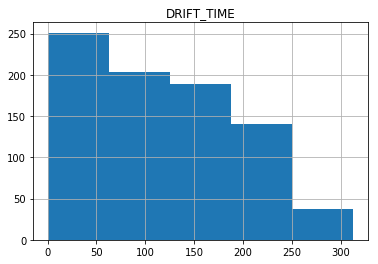

In [9]:
data_139l4.hist(column = 'DRIFT_TIME', bins = 5)

In [ ]:
#the tail is the cut over events with 2 cells in same layer (?)